
# Agrupamiento o Clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

## 1) ¿Qué es Clustering?

El _Clustering_ es una técnica de __aprendizaje no supervisado__ utilizada para descubrir estructuras subyacentes en conjuntos de datos que no poseen etiquetas. Su objetivo principal es encontrar agrupamientos naturales entre las observaciones, de modo que los elementos dentro de un mismo grupo sean lo más similares posible entre sí, y a la vez lo más diferentes posible de los elementos de otros grupos.

**Principales familias**:
- **Basados en prototipos**: K-Means (asume clusters aproximadamente esféricos bajo distancia euclidiana).
- **Jerárquicos**: Clustering aglomerativo (fusiones de abajo hacia arriba, visualización con dendrogramas).
- **Basados en densidad**: DBSCAN (encuentra clusters de formas arbitrarias, marca los valores atípicos como ruido).

## 2) K-Means con datos sintéticos (make_blobs)

Comenzaremos con un conjunto de datos que se ajusta a las suposiciones de K-Means: clusters aproximadamente esféricos con varianzas similares.

Compararemos resultados sin y con escalado de características, calcularemos la curva del codo (Elbow) y realizaremos un análisis de silueta.


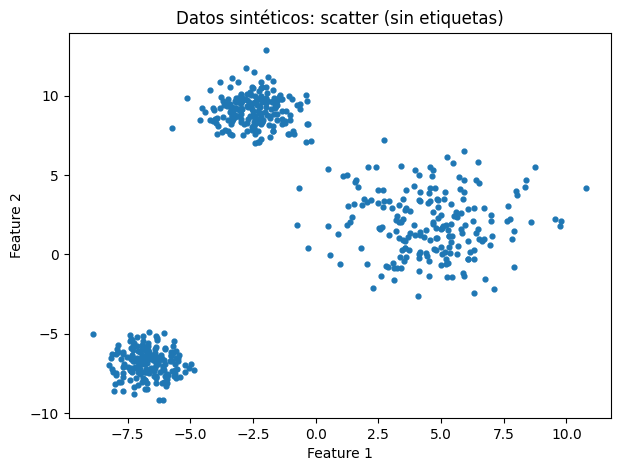

In [2]:
X_blobs, y_blobs = make_blobs(n_samples=600, centers=3, cluster_std=[1.0, 2.0, 0.8], random_state=42)

plt.figure(figsize=(7, 5))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], s=12)
plt.title("Datos sintéticos: scatter (sin etiquetas)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


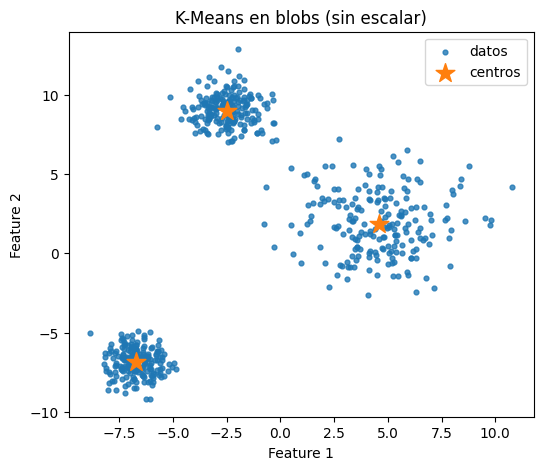

Inercia (SSE) sin escalar: 2214.907579143894


In [3]:

kmeans_raw = KMeans(n_clusters=3, n_init=10, random_state=42)
labels_raw = kmeans_raw.fit_predict(X_blobs)

plt.figure(figsize=(6, 5))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], s=12, alpha=0.8, label="datos")
centers_raw = kmeans_raw.cluster_centers_
plt.scatter(centers_raw[:, 0], centers_raw[:, 1], marker="*", s=200, label="centros")
plt.title("K-Means en blobs (sin escalar)")
plt.xlabel("Feature 1"); plt.ylabel("Feature 2")
plt.legend()
plt.show()

print("Inercia (SSE) sin escalar:", kmeans_raw.inertia_)


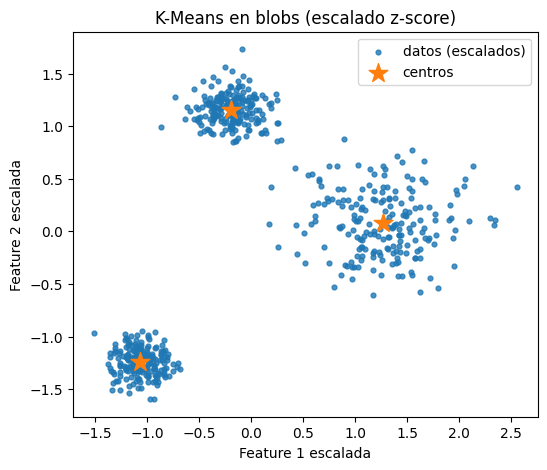

Inercia (SSE) con escalado: 71.64932998355138


In [4]:
# --- K-Means con escalado (z-score) ---
scaler = StandardScaler()
Xb_scaled = scaler.fit_transform(X_blobs)

kmeans_scaled = KMeans(n_clusters=3, n_init=10, random_state=42)
labels_scaled = kmeans_scaled.fit_predict(Xb_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(Xb_scaled[:, 0], Xb_scaled[:, 1], s=12, alpha=0.8, label="datos (escalados)")
centers_scaled = kmeans_scaled.cluster_centers_
plt.scatter(centers_scaled[:, 0], centers_scaled[:, 1], marker="*", s=200, label="centros")
plt.title("K-Means en blobs (escalado z-score)")
plt.xlabel("Feature 1 escalada"); plt.ylabel("Feature 2 escalada")
plt.legend()
plt.show()

print("Inercia (SSE) con escalado:", kmeans_scaled.inertia_)


### Diagrama de Voronoi

Cuando aplicamos K-means, cada punto del espacio se asigna al centroide más cercano. El _diagrama de Voronoi_ es una forma gráfica de visualizar estas regiones de decisión.

Un **diagrama de Voronoi** divide el plano (u otro espacio) en regiones, de modo que cada región contiene todos los puntos que están más cerca de un centroide específico que de cualquier otro.

Visualmente, esto nos permite ver las fronteras entre los clusters (zonas equidistantes entre dos o más centroides).

En el contexto de clustering, esta visualización nos ayuda a entender cómo K-means define sus decisiones de pertenencia, más allá de los puntos de entrenamiento.


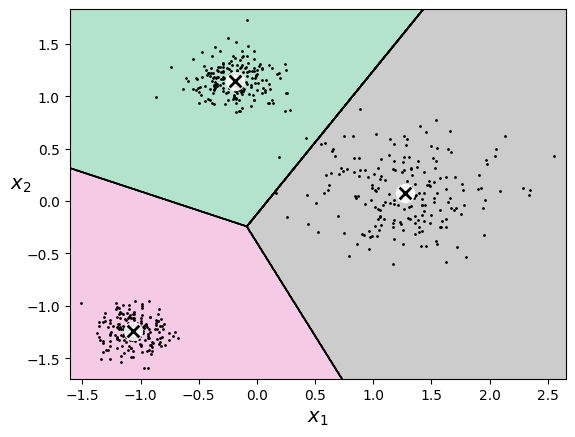

In [5]:
from modulos.graficacion import plot_decision_boundaries

kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)

kmeans.fit_predict(Xb_scaled)

plot_decision_boundaries(kmeans, Xb_scaled)

### ¿Qué es la **inercia** en K-Means?

La **inercia** (también llamada *SSE*: *Sum of Squared Errors*) mide qué tan compactos son los *clusters* que el algoritmo encontró.

Formalmente, la inercia se define como la **suma de las distancias cuadráticas** de cada punto a su centroide más cercano:

$$
\text{Inercia} = \sum_{i=1}^{n} \; \| x_i - \mu_j \|^2
$$

donde:

* $n$ es el número total de muestras,
* $x_i$ es cada punto i,
* $\mu_j$ es el centroide del *cluster* $j$,
* $\| x_i - \mu_j \|^2$ es la distancia euclidiana al cuadrado entre el punto y su centroide,

Cuanto menor sea este valor, **más compactos** son los clusters y es mejor el agrupamiento (según este criterio).

### Limitación importante

La inercia **siempre disminuye** cuando aumentamos el número de *clusters* $k$, porque más centroides pueden acercarse más a los puntos.
Por eso, no basta con minimizar la inercia: necesitamos un criterio adicional (como el **coeficiente de silueta**) para elegir un valor de $k$.

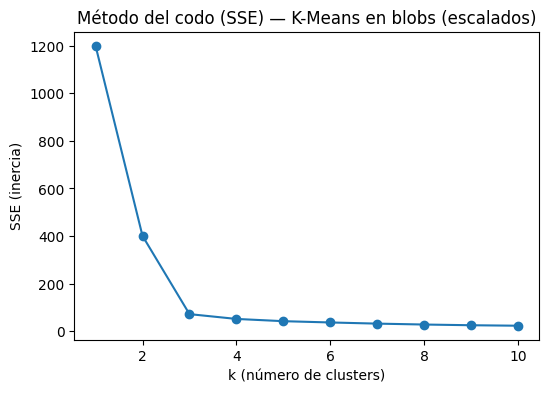

In [6]:
# --- Método del codo en datos escalados ---
K_range = range(1, 11)
sses = []
for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(Xb_scaled)
    sses.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(list(K_range), sses, marker="o")
plt.title("Método del codo (SSE) — K-Means en blobs (escalados)")
plt.xlabel("k (número de clusters)"); plt.ylabel("SSE (inercia)")
plt.show()


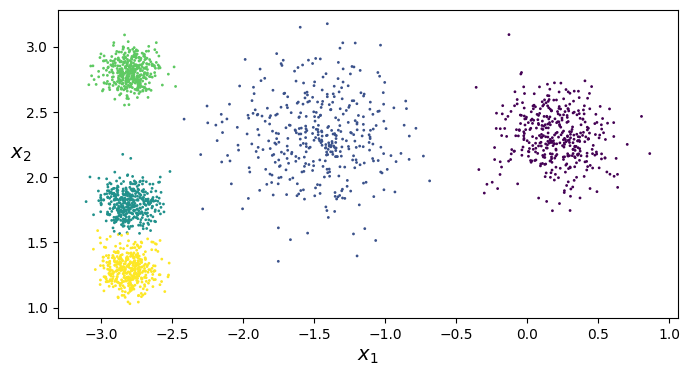

In [7]:
# Veamos otro ejemplo con blobs de diferente densidad y tamaño
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.2, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=1)

plt.figure(figsize=(8, 4))
plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.show()

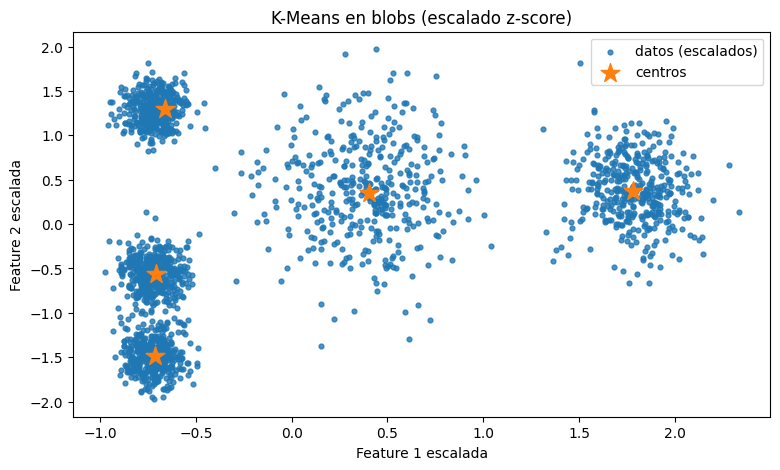

Inercia (SSE) con escalado: 242.89107703707492


In [8]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

kmeans_sc = KMeans(n_clusters=5, n_init=10, random_state=1)
labels_sc = kmeans_sc.fit_predict(X_sc)

plt.figure(figsize=(9, 5))
plt.scatter(X_sc[:, 0], X_sc[:, 1], s=12, alpha=0.8, label="datos (escalados)")
centers_sc = kmeans_sc.cluster_centers_
plt.scatter(centers_sc[:, 0], centers_sc[:, 1], marker="*", s=200, label="centros")
plt.title("K-Means en blobs (escalado z-score)")
plt.xlabel("Feature 1 escalada"); plt.ylabel("Feature 2 escalada")
plt.legend()
plt.show()

print("Inercia (SSE) con escalado:", kmeans_sc.inertia_)

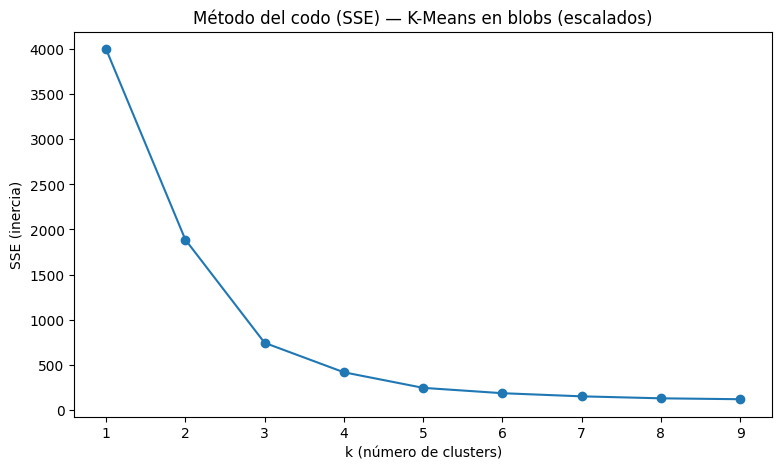

In [9]:
# --- Método del codo en datos escalados ---
kmeans_per_k = [ KMeans(n_clusters=k, n_init=10, random_state=1).fit(X_sc) for k in range(1, 10) ]
inertias = [ model.inertia_ for model in kmeans_per_k ]

plt.figure(figsize=(9, 5))
plt.plot(list(range(1, 10)), inertias, marker="o")
plt.title("Método del codo (SSE) — K-Means en blobs (escalados)")
plt.xlabel("k (número de clusters)"); plt.ylabel("SSE (inercia)")
plt.show()


### Análisis de **Silueta (Silhouette Analysis)**

El **análisis de silueta** es una técnica para evaluar qué tan bien quedaron definidos los *clusters* obtenidos en un algoritmo de *clustering*.
La idea es medir, para cada punto, **qué tan similar es a los puntos de su propio cluster comparado con los puntos de otros clusters**.

### Definición

Para cada punto $i$:

1. $a(i)$: la **distancia media** entre el punto $i$ y todos los demás puntos de su **mismo cluster**.
   → Mide qué tan compacto es el cluster para ese punto.

2. $b(i)$: la **distancia mínima media** entre el punto $i$ y todos los puntos de otro cluster (es decir, el cluster “vecino” más cercano).
   → Mide qué tan bien separado está el cluster del resto.

La **silueta** de un punto es:

$$
s(i) = \frac{b(i) - a(i)}{\max \{a(i), b(i)\}}
$$

* $s(i) \approx 1$: el punto está bien agrupado (muy cerca de su cluster y lejos de otros).
* $s(i) \approx 0$: el punto está en el borde entre dos clusters.
* $s(i) \approx -1$: el punto podría estar en el cluster equivocado.

### En scikit-learn

* `silhouette_score(X, labels)`
  → Calcula el **promedio de las siluetas** de todos los puntos.
  → Un valor alto (cercano a 1) indica clusters más definidos.

* `silhouette_samples(X, labels)`
  → Devuelve el **valor de silueta individual** de cada punto.
  → Muy útil para hacer un **gráfico de silueta**, donde se ven los clusters y la variabilidad de la calidad interna de cada uno.

El análisis de silueta no solo ayuda a evaluar la **calidad global del clustering**, sino que también revela si hay clusters mal definidos o si algunos puntos se encuentran mal asignados. Por eso suele usarse junto con el **método del codo**, como una herramienta complementaria para elegir el número óptimo de clusters $k$.

In [10]:
silhouette_scores = [silhouette_score(X_sc, model.labels_) for model in kmeans_per_k[1:]] #por lo menos 2 clusters
silhouette_scores

[0.5236151635982419,
 0.6237422868321257,
 0.6529167992957435,
 0.6675447165126006,
 0.6563189752159775,
 0.6102725247738214,
 0.6074040611490756,
 0.6021909706141628]

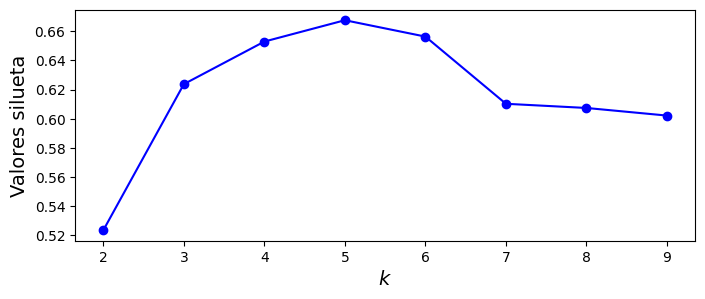

In [11]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Valores silueta", fontsize=14)
plt.show()

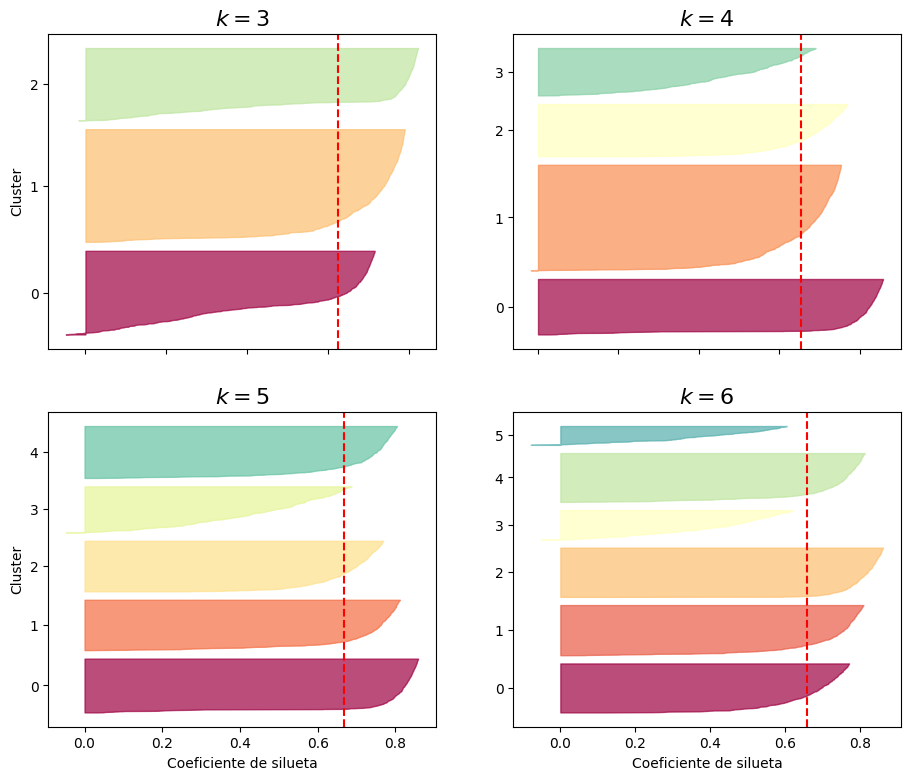

In [12]:
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_ #etiquetas de cada instancia de X
    silhouette_coefficients = silhouette_samples(X_sc, y_pred) #coeficientes para cada una de las instancias en X

    padding = len(X) // 30

    pos = padding
    ticks = []
    #Grafico los coeficientes de silueta por cada cluster
    for i in range(k): #i = 0,1,2..
        coeffs = silhouette_coefficients[y_pred == i] #coeficientes correspondientes a un cluster específico
        coeffs.sort()

        color = mpl.cm.Spectral(i / k) #colormap
        plt.fill_betweenx(y = np.arange(pos, pos + len(coeffs)), x1=0, x2=coeffs, facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        # plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Coeficiente de silueta")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

## 3) Clustering jerárquico aglomerativo (complete linkage)

En lugar de fijar de antemano el número de clusters, este método **construye una jerarquía de agrupamientos** que luego podemos “cortar” en el nivel que más nos convenga.

### ¿Cómo funciona el enfoque aglomerativo?

1. cada punto de datos arranca como su propio cluster individual.
2. Se mide las distancias entre clusters y unimos los dos más próximos.
3. El proceso se repite, fusionando clusters en cada paso, hasta que todos los puntos quedan unidos en un único gran cluster.

Este procedimiento se suele llamar “*bottom-up*” porque comienza desde abajo (puntos individuales) y va construyendo agrupaciones más grandes.

### La regla de *linkage*

El truco está en **cómo definimos la distancia entre clusters**. En *complete linkage*:

$$
d(A,B) = \max \{ d(x_i, x_j) : x_i \in A, \, x_j \in B \}
$$

Es decir, la distancia entre dos clusters $A$ y $B$ se toma como la **máxima distancia** entre cualquier par de puntos de los dos grupos.

* Esto tiende a producir **clusters más compactos y de tamaño similar**, porque evita que se unan dos grupos si tienen elementos muy alejados entre sí.
* En contraposición, el *single linkage* usa la distancia mínima (lo que puede generar cadenas largas y clusters alargados).

### El dendrograma

El resultado natural del clustering jerárquico es el **dendrograma**, un diagrama en forma de árbol que muestra **en qué orden** se fueron uniendo los clusters y **a qué distancia**.

* Si trazamos una línea horizontal a cierta altura, obtenemos un número de clusters.

### Ventajas

* No es necesario elegir $k$ de antemano.
* Proporciona una **visión jerárquica** de la estructura de los datos.
* Útil para descubrir subgrupos dentro de grupos.

### Limitaciones

* **Escalabilidad**: construir el dendrograma cuesta $O(n^2)$ en memoria y $O(n^3)$ en tiempo en el peor caso → no es práctico para datasets muy grandes.
* Puede ser sensible a la métrica de distancia y al tipo de linkage elegido.


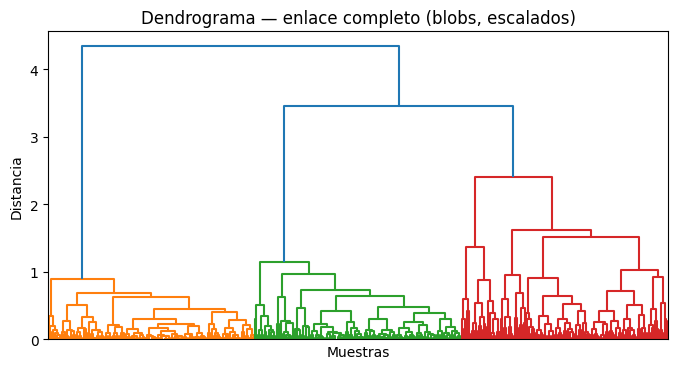

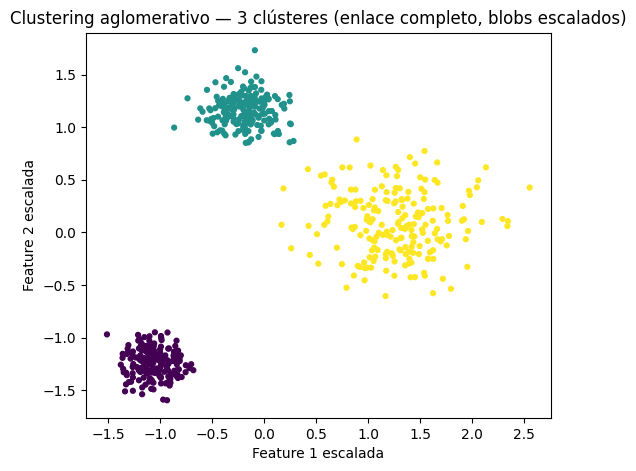

In [13]:

Xh = StandardScaler().fit_transform(X_blobs)

Z = linkage(Xh, method="complete", metric="euclidean")

# --- Dendrograma ---
plt.figure(figsize=(8, 4))
dendrogram(Z, no_labels=True, color_threshold=None)
plt.title("Dendrograma — enlace completo (blobs, escalados)")
plt.xlabel("Muestras"); plt.ylabel("Distancia")
plt.show()

hier_labels = fcluster(Z, t=3, criterion="maxclust")
# hier_labels = fcluster(Z, t=3, criterion="distance") # otra opción


plt.figure(figsize=(6, 5))
plt.scatter(Xh[:, 0], Xh[:, 1], s=12, c=hier_labels)
plt.title("Clustering aglomerativo — 3 clústeres (enlace completo, blobs escalados)")
plt.xlabel("Feature 1 escalada"); plt.ylabel("Feature 2 escalada")
plt.show()


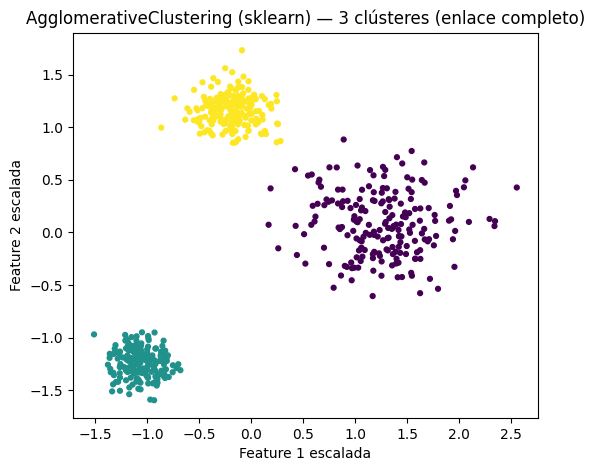

In [14]:
# Usando directamente AgglomerativeClustering de scikit-learn para comparación
ac = AgglomerativeClustering(n_clusters=3, metric="euclidean", linkage="complete")
labels_ac = ac.fit_predict(Xh)

plt.figure(figsize=(6, 5))
plt.scatter(Xh[:, 0], Xh[:, 1], s=12, c=labels_ac)
plt.title("AgglomerativeClustering (sklearn) — 3 clústeres (enlace completo)")
plt.xlabel("Feature 1 escalada"); plt.ylabel("Feature 2 escalada")
plt.show()


## 4) DBSCAN en formas no esféricas (`make_halfmoons`)

Un límite importante de algoritmos como **K-Means** o incluso el clustering jerárquico con enlace completo es que asumen implícitamente clusters con forma **aproximadamente esférica** bajo la distancia euclidea. Por eso, cuando trabajamos con conjuntos de datos con estructuras más complejas, como el clásico ejemplo de las dos *media lunas*.

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**.

* Define un **núcleo de densidad**: puntos que tienen al menos un número mínimo de vecinos dentro de un radio (`eps`).
* Los clusters se forman a partir de estos núcleos conectados por densidad, expandiéndose hacia los puntos alcanzables.
* Los puntos que no cumplen con los criterios de densidad se marcan como **ruido** (outliers).

Esto le da dos ventajas clave:

1. **Detectar clusters de forma arbitraria** (curvas, anillos, media lunas), que los métodos basados en prototipos no pueden.
2. **Identificar outliers naturalmente**, sin tener que asignarlos forzosamente a un cluster.

* `eps` (radio de vecindad), que determina qué tan cerca deben estar los puntos para considerarse vecinos.
* `min_samples` (mínimo de vecinos requeridos para que un punto sea núcleo), que controla la robustez frente al ruido.

DBSCAN es ideal para datos donde la **densidad local** es más representativa de la estructura que la **distancia media a un centro**.

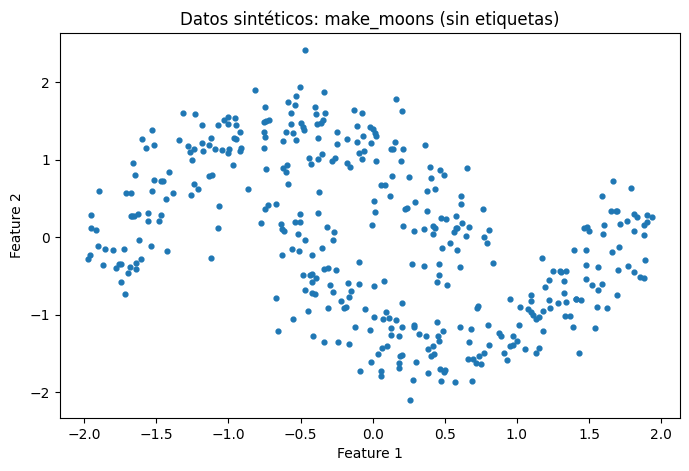

In [15]:
X_moons, y_moons = make_moons(n_samples=400, noise=0.15, random_state=1)
Xm = StandardScaler().fit_transform(X_moons)

plt.figure(figsize=(8, 5))
plt.scatter(Xm[:, 0], Xm[:, 1], s=12)
plt.title("Datos sintéticos: make_moons (sin etiquetas)")
plt.xlabel("Feature 1"); plt.ylabel("Feature 2")
plt.show()


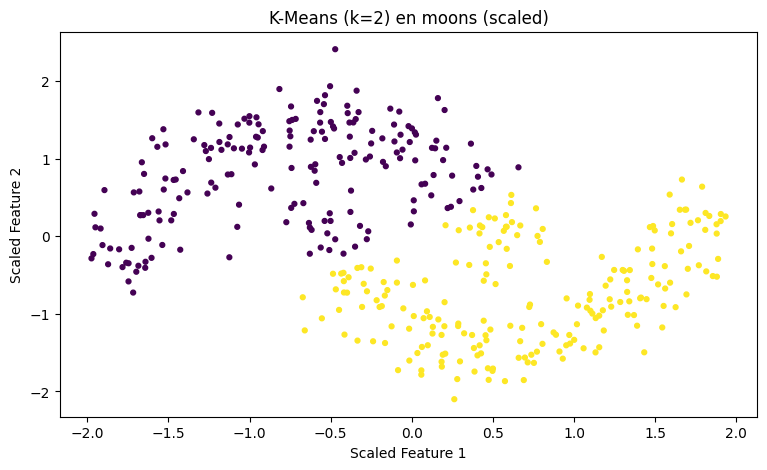

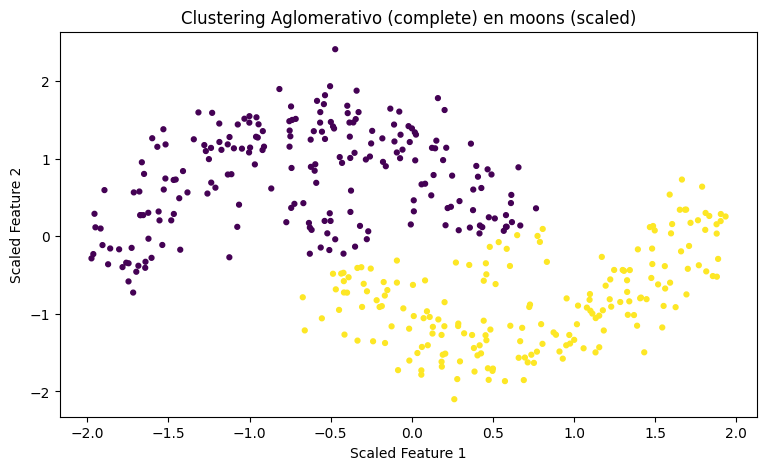

In [16]:
km_m = KMeans(n_clusters=2, n_init=10, random_state=1).fit(Xm)
labels_km = km_m.labels_

plt.figure(figsize=(9, 5))
plt.scatter(Xm[:, 0], Xm[:, 1], s=12, c=labels_km)
plt.title("K-Means (k=2) en moons (scaled)")
plt.xlabel("Scaled Feature 1"); plt.ylabel("Scaled Feature 2")
plt.show()

ac_m = AgglomerativeClustering(n_clusters=2, metric="euclidean", linkage="complete").fit(Xm)
labels_acm = ac_m.labels_

plt.figure(figsize=(9, 5))
plt.scatter(Xm[:, 0], Xm[:, 1], s=12, c=labels_acm)
plt.title("Clustering Aglomerativo (complete) en moons (scaled)")
plt.xlabel("Scaled Feature 1"); plt.ylabel("Scaled Feature 2")
plt.show()


DBSCAN encontró: 2 clusters, puntos de ruido: 9


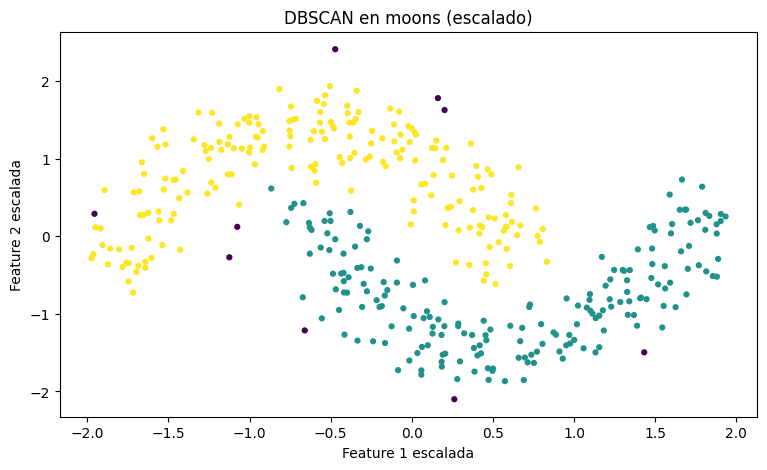

In [17]:
# --- DBSCAN en moons ---
db = DBSCAN(eps=0.25, min_samples=5, metric="euclidean").fit(Xm)
labels_db = db.labels_  # -1 = ruido

num_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
num_noise = np.sum(labels_db == -1)
print(f"DBSCAN encontró: {num_clusters} clusters, puntos de ruido: {num_noise}")

plt.figure(figsize=(9, 5))
plt.scatter(Xm[:, 0], Xm[:, 1], s=12, c=labels_db)
plt.title("DBSCAN en moons (escalado)")
plt.xlabel("Feature 1 escalada"); plt.ylabel("Feature 2 escalada")
plt.show()
